In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
from os.path import isfile, join
import pickle

import cell2location
from cell2location.plt.mapping_video import plot_spatial

plt.rcParams["axes.grid"] = False

from matplotlib import rcParams
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
sc.settings.verbosity = 0

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

palette = ['#199de5', '#fbbc04']
data_type = 'float32'
sc.settings.set_figure_params(dpi = 100, color_map = 'RdPu', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')
sc.settings.figdir = './figures-cell2location/'


def select_slide(adata_vis, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [2]:
path = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/visium/cell2location/'
path_data = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/visium/cell2location/'

donors = ["Hrv15", "Hrv27", 'F94', 'Hrv69']
# donors = ['Hrv69', "F91", "Hrv11" ,'F83',  'Hrv58']#["F83", "F91", "Hrv11"]#, 'F94']
# donors = ['F94', 'Hrv41' , "Hrv15", "Hrv27", "Hrv3", ]
donor2sample = {'females':["FCA_GNDST8796125", "FCA_GNDST8796126", 
                          "FCA_GNDST8796128", "FCA_GNDST8796127", 
                           "FCA_GNDST8796131", "FCA_GNDST8796132"],
               'Hrv41':['FCA_GNDST9421026'],
               'F81':['FCA_GNDST9421027'],
               'F83':["FCA_GNDST8796125", "FCA_GNDST8796126"], 
               'F91':["FCA_GNDST8796127", "FCA_GNDST8796128"],
               'Hrv11':["FCA_GNDST8796131", "FCA_GNDST8796132"],
               'Hrv69':['FCA_GNDST10484130', 'FCA_GNDST10484131'],
               'Hrv58':['FCA_GNDST10484129','FCA_GNDST10484132'],
               'Hrv3':['FCA_GNDST10485488'],
               'Hrv27':['FCA_GNDST10485487'],
               'Hrv13':['FCA_GNDST10485485'],
               'Hrv15':['FCA_GNDST10485486'],
               'males':["FCA_GNDST8796129", "FCA_GNDST8796130", 'FCA_GNDST9421026'],
               'F94':["FCA_GNDST8796129", "FCA_GNDST8796130"]}

sample2donor = {"FCA_GNDST8796125":'F83', 
                "FCA_GNDST8796126":'F83',
                'FCA_GNDST9421027':'F81',
                "FCA_GNDST8796127":'F91', 
                "FCA_GNDST8796128":'F91',
                "FCA_GNDST8796131":'Hrv11', 
                "FCA_GNDST8796132":'Hrv11',
                'FCA_GNDST9421024':'Hrv39',
                'FCA_GNDST9421026':'Hrv41',
                'FCA_GNDST10484130':"Hrv69", 
                'FCA_GNDST10484131':"Hrv69",
                "FCA_GNDST8796129":'F94',
                "FCA_GNDST8796130":'F94'
}

In [20]:
cluster_sets = {'Supporting_I': ['early_somatic', 'early_supporting',  'early_sPAX8', 'late_sPAX8'],
                'granulosa_I': [ 'OSE', 'preGC_IIa',   'preGC_I'],
                'granulosa_II': [ 'OSE',  'preGC_IIa',  'preGC_IIb', 'preGC_I'],
                'granulosa_III': ['preGC_IIa',  'preGC_IIb', 'granulosa',  'preGC_I'],
                'granulosa_IV': ['OSE',  'preGC_IIa',  'granulosa', 'preGC_I'],
                'granulosa_all': ['OSE',  'preGC_IIa', 'preGC_IIb',  'preGC_I', 'granulosa'],
                'follicle': ['granulosa',  'oocyte'],
                 'Germ cells I': ['PGC', 'GC',  'pre_spermatogonia'],
                 'Germ cells II': ['PGC',  'oogonia_meiotic', 'pre_oocyte',  'oocyte'],
                 'Germ cells III': ['PGC', 'oogonia_STRA8',  'oogonia_meiotic',  'pre_oocyte'],
                 'Germ cells all': ['PGC', 'GC',  'oogonia_STRA8',  'oogonia_meiotic',  'pre_oocyte', 'oocyte'],
                 'Germ cells IV': ['PGC', 'GC_mitotic', 'pre_spermatogonia'],
                 'Mesothelial_Supp': ['coelEpi_GATA2', 'coelEpi_LHX9',  'OSE'],
                'other_I': ['lymphoid', 'myeloid', 'Erythroid', 'Immune'],
                'other_II': ['PV', 'Epithelial', 'Endothelial'],
                'sem_tubules': ['late_sPAX8', 'Sertoli', 'FetalLeydig', 'Ti'],
#                  'Mesenchymal_O': ['Gi',  'Oi'],
                 'Mesenchymal_T': ['Gi',  'FetalLeydig', 'Ti'],
                 'Mesenchymal_M_I': [  'Mesenchymal_GATA2', 'Ti', 'Oi', 'OSE'],
                 'Mesenchymal_M_II': [  'Mesenchymal_GATA2', 'Ti', 'Oi', 'FetalLeydig']
               }

In [31]:
for donor in donors:
    print(donor)
    sc.settings.figdir = './figures-cell2location/'+donor+'/'
    for visium_slide in donor2sample[donor]:
        print(visium_slide)
        # Load cell2location results
        results_folder = path+donor+'/cell2location/'
        run_name = [f for f in listdir(path+donor+'/cell2location/std_model/') if 'LocationModel' in f]
        sp_data_file = results_folder + 'std_model/'+run_name[0]+'/sp.h5ad'
        adata_vis = anndata.read(sp_data_file)

        # Load scRNAseq reference to remind the clusters
        scRNAseq_file = [f for f in listdir(path_data+donor) if isfile(join(path_data+donor, f)) and 'scRNAseq' in f]
        adata_raw_sc = sc.read(path_data+donor+'/'+scRNAseq_file[0])
        # set(adata_raw_sc.obs.labels.values)

        # Visualisation of cell locations
        slide = select_slide(adata_vis, visium_slide)

        for clset in cluster_sets.keys():
            print(clset)
            # visualise locations of multiple cell types at once using absolute mRNA counts
            sel_clust = cluster_sets[clset]
            sel_clust = [value for value in sel_clust if value in adata_vis.uns.data['mod']['fact_names'].tolist()] 
            if len(sel_clust) > 0:
#                 sel_clust_col = ['mean_nUMI_factors' + str(i) for i in sel_clust]

#                 with mpl.rc_context({'figure.figsize': (15, 15)}):
#                     fig = plot_spatial(slide.obs[sel_clust_col], 
#                                   coords=slide.obsm['spatial'] \
#                                           * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
#                                   show_img=True, img_alpha=0.8,
#                                   img=list(slide.uns['spatial'].values())[0]['images']['hires'],
#                                   circle_diameter=4, labels=sel_clust, colorbar_position='right')


                # plot the 5% quantile of the posterior distribution on the number of UMI 
                # which shows the mRNA count assigned to each cell type with high confidence.    
                sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

                with mpl.rc_context({'figure.figsize': (15, 15)}):
                    fig = plot_spatial(slide.obs[sel_clust_col],
                           coords=slide.obsm['spatial'] \
                                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
                                       show_img=True, img_alpha=0.8,
                                       img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                                       style='fast', # fast or dark_background
                                       white_spacing=20,
                                       circle_diameter=5,
                                       labels=sel_clust, 
                                       reorder_cmap=(0,1,4,2,3),
                                      colorbar_shape = {'vertical_gaps': 0.5, 'horizontal_gaps': 0.1, 'width': 0.1, 'height': 0.05},
                                       colorbar_position='right')
                    plt.savefig(fname = 'figures-cell2location/'+donor+'/'+visium_slide+'_'+clset+'_q05_spot_factors_'+clset+'.pdf', 
                                dpi=None, facecolor='w', edgecolor='w',
                            orientation='landscape', papertype=None, format='pdf',
                            transparent=False, bbox_inches=None, pad_inches=0.1,
                            frameon=None, metadata=None)

                sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]
    
    
                # plot with nice names
                with mpl.rc_context({'figure.figsize': (10, 10), "font.size": 18}):
                    slide.obs[sel_clust] = (slide.obs[sel_clust_col])
                    sc.pl.spatial(slide, cmap='viridis',
                                  color=sel_clust[0:6], # limit size in this notebook
                                  ncols=3,
                                  size=0.9, img_key='hires',
                                  alpha_img=0.5,
                                  vmin=0, vmax='p99.2',
                                  save = '_'+donor+'_'+visium_slide+'_'+clset+'_q05_spot_factors.pdf',
                                  show = False
                                 )

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.


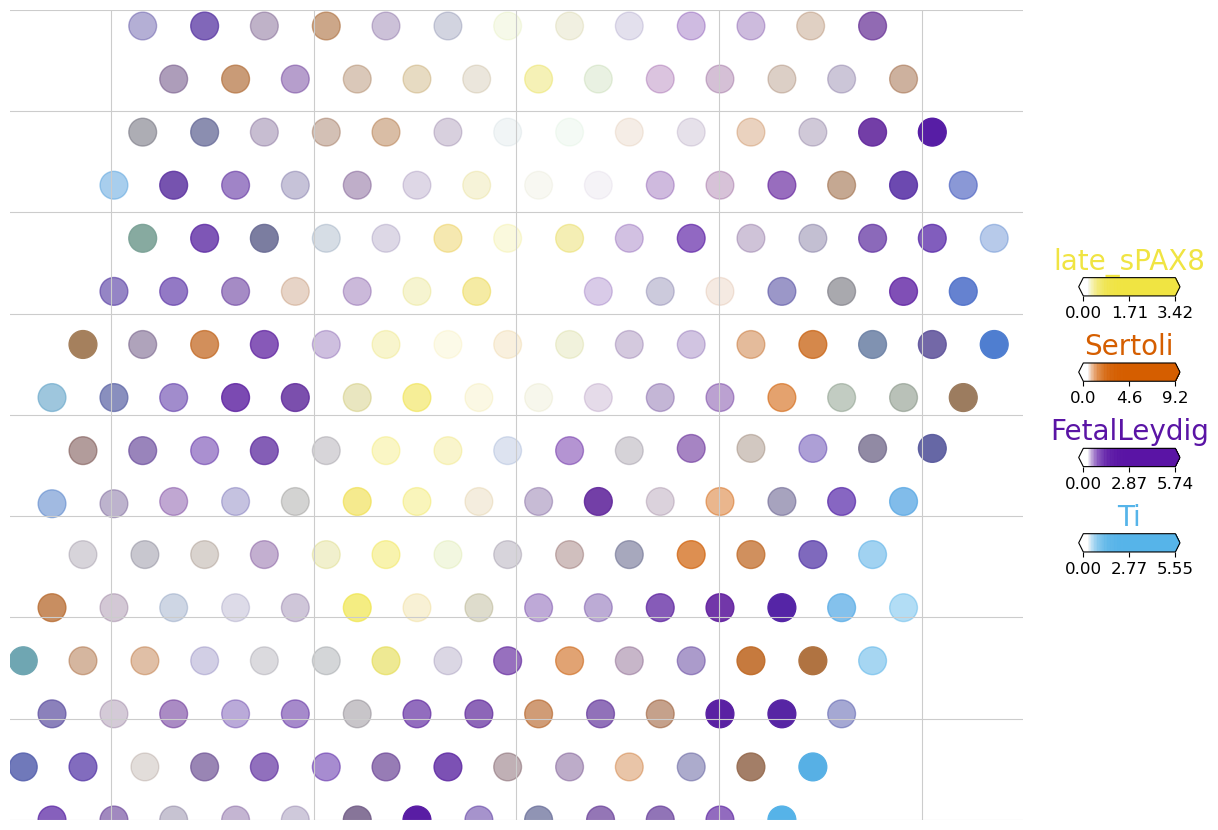

In [24]:
donor = 'Hrv15'
visium_slide = 'FCA_GNDST10485486'

# Load cell2location results
results_folder = path+donor+'/cell2location/'
run_name = [f for f in listdir(path+donor+'/cell2location/std_model/') if 'LocationModel' in f]
sp_data_file = results_folder + 'std_model/'+run_name[0]+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# Load scRNAseq reference to remind the clusters
scRNAseq_file = [f for f in listdir(path_data+donor) if isfile(join(path_data+donor, f)) and 'scRNAseq' in f]
adata_raw_sc = sc.read(path_data+donor+'/'+scRNAseq_file[0])
# set(adata_raw_sc.obs.labels.values)

# Visualisation of cell locations
slide = select_slide(adata_vis, visium_slide)

clset =  'sem_tubules'


# # identify spot locations to crop near tissue
# crop_max = (slide.obsm['spatial'] \
#             * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
# crop_min = (slide.obsm['spatial'] \
#             * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

# crop_x = [crop_min[0]-50, crop_max[0]+50]
# crop_y = [crop_min[1]+20, crop_max[1]-20]

# crop_x = [1100, 1425] # 'Hrv15' - right sample
# crop_y = [475, 1125]

crop_x = [1125, 1375] # 'Hrv15' - right sample - rete testis
crop_y = [800, 1000]

# crop_x = [700, 900] # 'Hrv15' - left sample
# crop_y = [200, 400]


# crop_x = [570, 985] # 'Hrv27'- top left
# crop_y = [150, 525]

# crop_x = [700, 985] # 'Hrv27'- top left half gonad
# crop_y = [300, 525]

# crop_x = [1150, 1425] # 'Hrv27' - rigth
# crop_y = [275, 725]


# crop_x = [575, 800] # Hrv69 - left
# crop_y = [200, 500]

# crop_x = [1050, 1300] # Hrv69 - right
# crop_y = [300, 700]



# visualise locations of multiple cell types at once using absolute mRNA counts
sel_clust = cluster_sets[clset]
sel_clust = [value for value in sel_clust if value in adata_vis.uns.data['mod']['fact_names'].tolist()] 
if len(sel_clust) > 0:
    sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

    with mpl.rc_context({'figure.figsize': (15, 15)}):
        fig = plot_spatial(slide.obs[sel_clust_col],
               coords=slide.obsm['spatial'] \
                              * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
                           show_img=False, img_alpha=0.8,
                           img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                           style='fast', # fast or dark_background
                           white_spacing=5,
                           circle_diameter=20,
                           labels=sel_clust, 
                           crop_x=crop_x, crop_y=crop_y,
                           reorder_cmap=(0, 1, 4, 2, 3),
                          colorbar_shape = {'vertical_gaps': 0.5, 'horizontal_gaps': 0.1, 'width': 0.1, 'height': 0.05},
                           colorbar_position='right')
        plt.savefig(fname = 'figures-cell2location/'+donor+'/ZOOMin_'+visium_slide+'_'+clset+'_q05_spot_factors_'+clset+'_II_noimage.pdf', 
                    dpi=1200, facecolor='w', edgecolor='w',
                orientation='landscape', papertype=None, format='pdf',
                transparent=True, bbox_inches=None, #pad_inches=0.1,
                frameon=None, metadata=None)

In [ ]:
#Identify co-occuring cell type combinations using matrix factorisation


for donor in donors:
        print(donor)
        sc.settings.figdir = './figures-cell2location/'+donor+'/'
         
        # Load cell2location results
        results_folder = path+donor+'/cell2location/'
        run_name = [f for f in listdir(path+donor+'/cell2location/std_model/') if 'LocationModel' in f]
        sp_data_file = results_folder + 'std_model/'+run_name[0]+'/sp.h5ad'
        adata_vis = anndata.read(sp_data_file)

        # Load scRNAseq reference to remind the clusters
        scRNAseq_file = [f for f in listdir(path_data+donor) if isfile(join(path_data+donor, f)) and 'scRNAseq' in f]
        adata_raw_sc = sc.read(path_data+donor+'/'+scRNAseq_file[0])
        # set(adata_raw_sc.obs.labels.values)
        
        # number of cell type combinations - educated guess assuming that most cell types don't co-locate
        n_fact = int(4)

        # extract cell abundance from cell2location
        X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

        import cell2location.models as c2l
        # create model class
        mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
                n_iter = 10000,
                verbose = True,
                var_names=adata_vis.uns['mod']['fact_names'],
                obs_names=adata_vis.obs_names,
                fact_names=['fact_' + str(i) for i in range(n_fact)],
                sample_id=adata_vis.obs['sample'],
                init='random', random_state=0,
                nmf_kwd_args={'tol':0.0001})

        # train 5 times to evaluate stability
        mod_sk.fit(n=5, n_type='restart')


        ## Do some diagnostics
        # evaluate stability by comparing trainin restarts

        with mpl.rc_context({'figure.figsize': (10, 8)}):
            mod_sk.evaluate_stability('cell_type_factors', align=True)


        # evaluate accuracy of the model
        mod_sk.compute_expected()
        mod_sk.plot_posterior_mu_vs_data()


        # extract parameters into DataFrames
        mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

        # export results to scanpy object
        adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
        adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

        # print the fraction of cells of each type located to each combination
        mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                                 gene_fact_name='cell_type_fractions')


        # make nice names
        from re import sub
        mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                              for i in mod_sk.cell_type_fractions.columns]

        # plot co-occuring cell type combinations
        mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                                fact_filt=mod_sk.fact_filt,
                                loadings_attr='cell_type_fractions',
                                gene_fact_name='cell_type_fractions',
                                cmap='RdPu', figsize=[5, 6])
        plt.savefig('figures-cell2location/'+donor+'/microenviroments_cooccuringCombinations.pdf', dpi=75, figsize=(8,15))
        # write csv
        gene_loadings = getattr(mod_sk, 'cell_type_fractions').copy()
        gene_loadings.to_csv('figures-cell2location/'+donor+'/microenviroments_cooccuringCombinations.csv', index=True) 


        # plot cell density in each combination
        for i in range(len(donor2sample[donor])):
            with mpl.rc_context({'figure.figsize': (5, 6), 'axes.facecolor': 'black'}):
                sc.pl.spatial(adata_vis[adata_vis.obs['sample'].isin([adata_vis.obs['sample'].unique()[i]]),:],
                              cmap='magma', library_id=list(adata_vis.uns['spatial'].keys())[i],
                              color=mod_sk.location_factors_df.columns,
                              ncols=6,
                              size=1, img_key='hires',
                              alpha_img=0,
                              vmin=0, vmax='p99.2',
                              save = donor+'_'+donor2sample[donor][i]+'_microenviroments_cooccuringCombinations.pdf',
                              show = False
                             )

        # save co-location models object
        def pickle_model(mod, path, file_suffix=''):
            file = 'figures-cell2location/'+donor+'/model_' + str(mod.__class__.__name__) + '_' + str(mod.n_fact) + '_' + file_suffix + ".p"
            pickle.dump({'mod': mod, 'fact_names': mod.fact_names}, file = open(file, "wb"))
            print(file)

        pickle_model(mod_sk, 'figures-cell2location/'+donor+'/', file_suffix='')

In [ ]:
# Automatic discrete region identification by clustering cell densities

for donor in donors:
    
    print(donor)
    sc.settings.figdir = './figures-cell2location/'+donor+'/'
    
    # Load cell2location results
    results_folder = path+donor+'/cell2location/'
    run_name = [f for f in listdir(path+donor+'/cell2location/std_model/') if 'LocationModel' in f]
    sp_data_file = results_folder + 'std_model/'+run_name[0]+'/sp.h5ad'
    adata_vis = anndata.read(sp_data_file)

    # Load scRNAseq reference to remind the clusters
    scRNAseq_file = [f for f in listdir(path_data+donor) if isfile(join(path_data+donor, f)) and 'scRNAseq' in f]
    adata_raw_sc = sc.read(path_data+donor+'/'+scRNAseq_file[0])
    # set(adata_raw_sc.obs.labels.values)
        
        
    sample_type = 'q05_nUMI_factors'
    col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
    adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

    # compute KNN using the cell2location output
    sc.pp.neighbors(adata_vis, use_rep=sample_type)

    # Cluster spots into regions using scanpy
    sc.tl.leiden(adata_vis, resolution=0.4)

    # add region as categorical variable
    adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
    adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

    # Plot the region identity of each location in 2D space
    spt_keys =  list(adata_vis.uns['spatial'].keys())
    for sa in donor2sample[donor]:
        with mpl.rc_context({'figure.figsize': (5, 6)}):
            matching = [s for s in spt_keys if sa in s]
            sc.pl.spatial(adata_vis[adata_vis.obs["sample"]==sa],  library_id=matching[0], color=["region_cluster"], img_key=None, 
                          save = '_'+donor+'_'+sa+'_spot_density_clusters.pdf')



    sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)
    with mpl.rc_context({'figure.figsize': (8, 8)}):
        sc.pl.umap(adata_vis, color=['sample', 'region_cluster'], size=30,
                   color_map = 'RdPu', ncols = 2, legend_loc='on data',
                   legend_fontsize=10,
                   save = '_'+donor+'_spot_density_UMAP.pdf')
        
    adata_vis.obs.to_csv('figures-cell2location/'+donor+'/cellLocations_clustering_metadata.tsv', sep = '\t')
    pd.DataFrame(data=adata_vis.obsm['X_umap']).to_csv('figures-cell2location/'+donor+'/cellLocations_UMAP.tsv', sep = '\t')